#Project 5: Implementing a Recommender System on Spark
By Latif Masud

For this assignment, I chose to implement Apache Spark two different ways to observe the speed difference between running standard Python code, and running the code in Spark on Databricks Community Edition, and running Spark locally via a Docker container. 

##Recommender System
Below is the code from the collaborative filtering recommender system from Project Two. It has been modified a bit to run as a standalone function that returns results. 

In [2]:
from numpy import *
from scipy import optimize

def normalize_ratings(ratings, did_rate):
    num_movies = ratings.shape[0]
    
    ratings_mean = zeros(shape = (num_movies, 1))
    ratings_norm = zeros(shape = ratings.shape)
    
    for i in range(num_movies): 
        idx = where(did_rate[i] == 1)[0]
        
        #  Calculate mean 
        ratings_mean[i] = mean(ratings[i, idx])
        ratings_norm[i, idx] = ratings[i, idx] - ratings_mean[i]
    
    return ratings_norm, ratings_mean

def unroll_params(X_and_theta, num_users, num_movies, num_features):
    m = X_and_theta[:num_movies * num_features]
    x = m.reshape((num_features, num_movies)).transpose()
    y = X_and_theta[num_movies * num_features:]
    theta = y.reshape(num_features, num_users ).transpose()
    return x, theta

def calculate_gradient(X_and_theta, ratings, did_rate, num_users, num_movies, num_features, reg_param):
	X, theta = unroll_params(X_and_theta, num_users, num_movies, num_features)
	
	# we multiply by did_rate because we only want to consider observations for which a rating was given
	difference = X.dot( theta.T ) * did_rate - ratings
	X_grad = difference.dot( theta ) + reg_param * X
	theta_grad = difference.T.dot( X ) + reg_param * theta
	
	# wrap the gradients back into a column vector 
	return r_[X_grad.T.flatten(), theta_grad.T.flatten()]

def calculate_cost(X_and_theta, ratings, did_rate, num_users, num_movies, num_features, reg_param):
    X, theta = unroll_params(X_and_theta, num_users, num_movies, num_features)

    cost = sum( (X.dot( theta.T ) * did_rate - ratings) ** 2 ) / 2
    regularization = (reg_param / 2) * (sum( theta**2 ) + sum(X**2))
    return cost + regularization

def generate_predictions (num_users, num_movies):
	ratings = random.randint(11, size= (num_movies, num_users))

	did_rate = (ratings != 0)*1

	ratings, ratings_mean = normalize_ratings(ratings, did_rate)
	num_users = ratings.shape[1]
	num_features = 3

	movie_features = random.randn( num_movies, num_features )
	user_prefs = random.randn( num_users, num_features )
	initial_X_and_theta = r_[movie_features.T.flatten(), user_prefs.T.flatten()]

	reg_param = 30
    
	minimized_cost_and_optimal_params = optimize.fmin_cg(
		calculate_cost, 
		fprime=calculate_gradient, 
		x0=initial_X_and_theta,
		args=(ratings, did_rate, num_users, num_movies, num_features, reg_param),
		maxiter=100, disp=True, full_output=True)


	cost, optimal_movie_features_and_user_prefs = minimized_cost_and_optimal_params[1], minimized_cost_and_optimal_params[0]
	movie_features, user_prefs = unroll_params(optimal_movie_features_and_user_prefs, num_users, num_movies, num_features)
	all_predictions = movie_features.dot( user_prefs.T )

	# predictions_for_latif = all_predictions[:, 0:1] + ratings_mean
	# print predictions_for_latif
	return ratings, all_predictions

##Running Spark in Docker
To run Spark in Docker, take the following steps:
1. First download Docker for your given operating system from https://www.docker.com/get-docker. 
2. After that, open a terminal or command line window and download Jupyter All Spark Notebook by entering: `docker pull jupyter/all-spark-notebook`. 
3. Once the download is complete, run Spark by entering: `docker run -it --rm -p 8888:8888 jupyter/all-spark-notebook`. 

##Generating Runtimes
The `generate_runtimes` function calculates runtimes of utilizing the collabortive filtering function for given number of movies and users based on start point, end point, and the number of iterations. For this example, I chose to run up to 300 movies and users with a iterator of 25. The `datetime` library is used to calcualte the runtimes of each iteration. 

In [10]:
from datetime import datetime

def generate_runtimes (start, end, iteration):
    times = []
    for num_movies in range(10, 301, 25):
      iter_times = []
      for num_users in range(10, 301, 25):  
        start=datetime.now()
        ratings, predictions = generate_predictions (num_users, num_movies)
        time= datetime.now()-start
        iter_times.append(time.total_seconds())
      times.append(iter_times)

    return times

##Results
The results for Spark were copied in from runs in Databricks and local Spark session where the `generate_runtime` function was run, the same way it is below for regular Python.

In [12]:
noSparkMacBook = generate_runtimes(10,300,25)
sparkDataBricks= [[0.006208, 0.008258, 0.012768, 0.031177, 0.026492, 0.027244, 0.020445, 0.024691, 0.029276, 0.024906, 0.018771, 0.037219], [0.007815, 0.018825, 0.022381, 0.024374, 0.038096, 0.026226, 0.038527, 0.040478, 0.037034, 0.046387, 0.051933, 0.050853], [0.013675, 0.034233, 0.038488, 0.036409, 0.043455, 0.046566, 0.045243, 0.050625, 0.061584, 0.061628, 0.069775, 0.086586], [0.018073, 0.039274, 0.041334, 0.03115, 0.05202, 0.057327, 0.05704, 0.061534, 0.070647, 0.078345, 0.084996, 0.092733], [0.034718, 0.041083, 0.031236, 0.056775, 0.058973, 0.057775, 0.071139, 0.084392, 0.086091, 0.098019, 0.087522, 0.108962], [0.026225, 0.048011, 0.043785, 0.049405, 0.066111, 0.080224, 0.060206, 0.089094, 0.095488, 0.102242, 0.106252, 0.118595], [0.033666, 0.039117, 0.056158, 0.068072, 0.07445, 0.08358, 0.079275, 0.096468, 0.106584, 0.117736, 0.116577, 0.13585], [0.03882, 0.047986, 0.051002, 0.07468, 0.078852, 0.091217, 0.096643, 0.115734, 0.125029, 0.141538, 0.143743, 0.148836], [0.034964, 0.051443, 0.067287, 0.079351, 0.08642, 0.095309, 0.111988, 0.144581, 0.132671, 0.143443, 0.143092, 0.165633], [0.043844, 0.054662, 0.053586, 0.084874, 0.098558, 0.109387, 0.117954, 0.130039, 0.140842, 0.153705, 0.165409, 0.180071], [0.043403, 0.054683, 0.072959, 0.089311, 0.101487, 0.116983, 0.125305, 0.142771, 0.142636, 0.167466, 0.171065, 0.197173], [0.046434, 0.0634, 0.061063, 0.075132, 0.105914, 0.120081, 0.135059, 0.150472, 0.166148, 0.184072, 0.199672, 0.204208]]
sparkMacBook = [[0.016505, 0.017197, 0.014189, 0.01515, 0.023791, 0.015523, 0.026744, 0.024587, 0.019974, 0.027449, 0.005271, 0.032918], [0.008008, 0.017577, 0.02686, 0.031338, 0.030985, 0.032659, 0.028132, 0.032027, 0.038164, 0.051359, 0.041023, 0.054078], [0.013447, 0.037154, 0.031542, 0.024656, 0.027915, 0.040106, 0.041342, 0.058982, 0.100416, 0.18228, 0.067739, 0.068701], [0.085854, 0.204836, 0.14247, 0.05237, 0.066917, 0.039443, 0.059915, 0.052941, 0.075115, 0.084361, 0.094591, 0.118967], [0.017032, 0.032477, 0.037702, 0.055135, 0.168144, 0.136257, 0.13346, 0.159041, 0.180962, 0.13769, 0.218041, 0.222594], [0.039167, 0.065653, 0.066207, 0.134044, 0.117973, 0.165336, 0.082029, 0.233499, 0.19528, 0.238944, 0.114977, 0.13337], [0.020113, 0.031784, 0.043476, 0.091458, 0.210116, 0.136016, 0.217459, 0.156343, 0.121082, 0.095166, 0.138271, 0.146758], [0.029467, 0.056697, 0.063651, 0.067162, 0.073317, 0.090633, 0.094884, 0.122005, 0.285814, 0.307502, 0.321878, 0.311828], [0.040621, 0.036965, 0.070819, 0.188384, 0.148437, 0.182566, 0.11079, 0.135362, 0.136764, 0.172778, 0.199404, 0.173772], [0.026105, 0.04054, 0.058568, 0.185298, 0.235459, 0.232212, 0.122651, 0.154384, 0.306463, 0.347117, 0.195659, 0.335093], [0.044866, 0.099745, 0.146302, 0.15394, 0.14083, 0.197665, 0.332154, 0.195995, 0.199117, 0.290977, 0.209697, 0.266473], [0.03474, 0.068451, 0.188546, 0.195805, 0.239686, 0.285046, 0.31472, 0.231561, 0.462361, 0.264784, 0.221382, 0.454532]]


Optimization terminated successfully.
         Current function value: 380.448611
         Iterations: 13
         Function evaluations: 29
         Gradient evaluations: 29
Optimization terminated successfully.
         Current function value: 1279.345410
         Iterations: 18
         Function evaluations: 38
         Gradient evaluations: 38
Optimization terminated successfully.
         Current function value: 2144.544430
         Iterations: 28
         Function evaluations: 58
         Gradient evaluations: 58
         Current function value: 3355.676482
         Iterations: 100
         Function evaluations: 169
         Gradient evaluations: 169
Optimization terminated successfully.
         Current function value: 4140.948714
         Iterations: 55
         Function evaluations: 97
         Gradient evaluations: 97
         Current function value: 5093.444702
         Iterations: 100
         Function evaluations: 164
         Gradient evaluations: 164
         Current func

         Current function value: 64068.642026
         Iterations: 100
         Function evaluations: 163
         Gradient evaluations: 163
         Current function value: 72622.243948
         Iterations: 100
         Function evaluations: 163
         Gradient evaluations: 163
Optimization terminated successfully.
         Current function value: 81203.864207
         Iterations: 98
         Function evaluations: 155
         Gradient evaluations: 155
Optimization terminated successfully.
         Current function value: 88544.926127
         Iterations: 93
         Function evaluations: 151
         Gradient evaluations: 151
Optimization terminated successfully.
         Current function value: 3650.202637
         Iterations: 63
         Function evaluations: 111
         Gradient evaluations: 111
Optimization terminated successfully.
         Current function value: 13777.215186
         Iterations: 66
         Function evaluations: 112
         Gradient evaluations: 112
       

         Current function value: 91039.552618
         Iterations: 100
         Function evaluations: 161
         Gradient evaluations: 161
         Current function value: 107957.723853
         Iterations: 100
         Function evaluations: 159
         Gradient evaluations: 159
Optimization terminated successfully.
         Current function value: 125917.473007
         Iterations: 93
         Function evaluations: 146
         Gradient evaluations: 146
         Current function value: 141874.764347
         Iterations: 100
         Function evaluations: 155
         Gradient evaluations: 155
         Current function value: 157950.904064
         Iterations: 100
         Function evaluations: 160
         Gradient evaluations: 160
         Current function value: 175517.176218
         Iterations: 100
         Function evaluations: 155
         Gradient evaluations: 155
         Current function value: 193154.211648
         Iterations: 100
         Function evaluations: 156
     

Optimization terminated successfully.
         Current function value: 8790.010224
         Iterations: 93
         Function evaluations: 150
         Gradient evaluations: 150
         Current function value: 34615.555049
         Iterations: 100
         Function evaluations: 164
         Gradient evaluations: 164
         Current function value: 60469.572073
         Iterations: 100
         Function evaluations: 158
         Gradient evaluations: 158
Optimization terminated successfully.
         Current function value: 87921.332183
         Iterations: 97
         Function evaluations: 156
         Gradient evaluations: 156
         Current function value: 112900.346215
         Iterations: 100
         Function evaluations: 156
         Gradient evaluations: 156
         Current function value: 138511.266553
         Iterations: 100
         Function evaluations: 157
         Gradient evaluations: 157
         Current function value: 166433.424522
         Iterations: 100
       

###Regular Python Runs
We can see below the graph for regularly run Python without Spark. As expected, the larger the load, the higher the run time. The `matplotlib` library is used to generate the plots. 

12


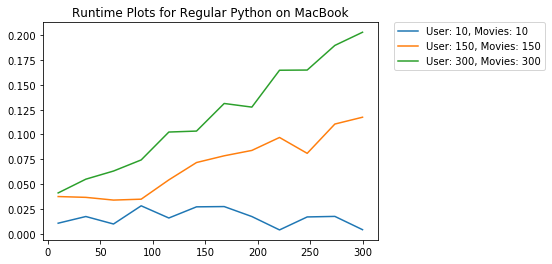

In [44]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

print (len(noSparkMacBook))
xi = np.linspace(10,300, 12)
plt.plot(xi, noSparkMacBook[0], label="User: 10, Movies: 10")
plt.plot(xi, noSparkMacBook[5], label="User: 150, Movies: 150")
plt.plot(xi, noSparkMacBook[11], label="User: 300, Movies: 300")
plt.title('Runtime Plots for Regular Python on MacBook')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

Below is the graph for Spark on Databricks. The graph (surprsingly) looks the same as the one from regular run of Python. 

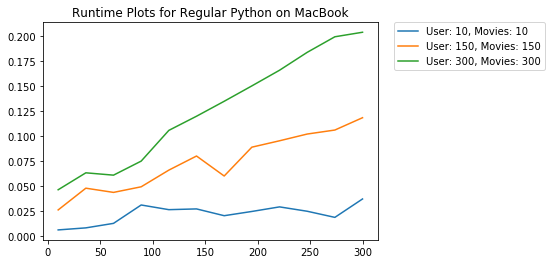

In [45]:
xi2 = np.linspace(10,300, 12)
plt.plot(xi2, sparkDataBricks[0], label="User: 10, Movies: 10")
plt.plot(xi2, sparkDataBricks[5], label="User: 150, Movies: 150")
plt.plot(xi2, sparkDataBricks[11], label="User: 300, Movies: 300")
plt.title('Runtime Plots for Spark on Databricks')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

Lastly, below is the graph for running Spark locally. This one is a bit more interesting as we see the max workload time spike up and down, often getting close to the workload runtime for the 150 user and movie case. My guess is that this is because of the CPU turbo-boosting. 

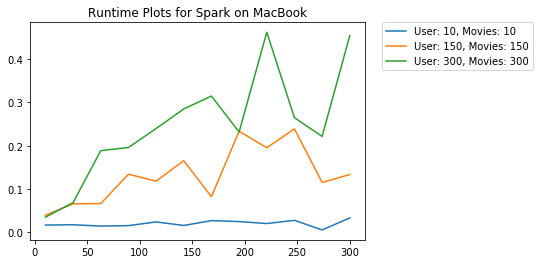

In [47]:
xi3 = np.linspace(10,300, 12)
plt.plot(xi3, sparkMacBook[0], label="User: 10, Movies: 10")
plt.plot(xi3, sparkMacBook[5], label="User: 150, Movies: 150")
plt.plot(xi3, sparkMacBook[11], label="User: 300, Movies: 300")
plt.title('Runtime Plots for Spark on MacBook')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

Finally, the graph below comparing the runtimes on Python and Spark on DataBricks and MacBook for 300 Users and Movies:

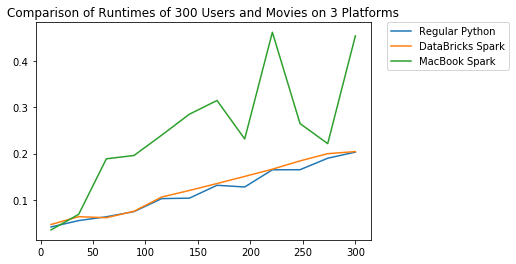

In [48]:
xi3 = np.linspace(10,300, 12)
plt.plot(xi3, noSparkMacBook[11], label="Regular Python")
plt.plot(xi3, sparkDataBricks[11], label="DataBricks Spark")
plt.plot(xi3, sparkMacBook[11], label="MacBook Spark")
plt.title('Comparison of Runtimes of 300 Users and Movies on 3 Platforms')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

##Conclusion
Interestingly, the Spark runtime on DataBricks is a tad bit higher, though much more consistent than running the script as a regular Python script. The Docker container is considerably slower in this situation. This is not what I was expecting. My expectation was that the locally run Spark would be the fastest since it would take advantage of all four core and all of the memory of the machine - which is more than the 6GB we get with Databricks Community Edition. My guess would be that the workloads are not large enough to take advantage of distributed computing, thus making it nearly the same speed as a regular Python script. 